<a href="https://colab.research.google.com/github/isaacdono/ml-studies/blob/main/deep%20learning/autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estudo Prático: Autoencoders

Um **Autoencoder** é um tipo de rede neural artificial usada para aprendizado não supervisionado de representações eficientes (codificações). O objetivo de um autoencoder é aprender uma representação (encoding) para um conjunto de dados, normalmente para redução de dimensionalidade ou extração de características.

Ele consiste em duas partes principais:
1.  **Encoder**: Uma rede que comprime os dados de entrada em uma representação latente de menor dimensão (o "encoding" ou "bottleneck").
2.  **Decoder**: Uma rede que tenta reconstruir os dados de entrada originais a partir da representação comprimida.

A rede é treinada para minimizar o **erro de reconstrução**, que é a diferença entre a entrada original e a saída reconstruída. Ao forçar os dados a passarem por um "gargalo" (bottleneck) de menor dimensão, a rede aprende as características mais importantes dos dados.

Neste notebook, vamos construir um autoencoder simples para comprimir e reconstruir imagens do famoso dataset **MNIST**.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist

print(f"TensorFlow versão: {tf.__version__}")
print("Bibliotecas importadas com sucesso!")

TensorFlow versão: 2.19.0
Bibliotecas importadas com sucesso!


In [2]:
# Carregando o dataset. Não precisamos dos rótulos (y_train, y_test) para treinar o autoencoder,
# mas vamos usá-los no final para visualização.
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Pré-processamento:
# 1. Normalizar os pixels para o intervalo [0, 1]
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# 2. Achatar as imagens 28x28 em vetores de 784 dimensões
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

print(f"Formato dos dados de treino: {x_train.shape}")
print(f"Formato dos dados de teste:  {x_test.shape}")

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Formato dos dados de treino: (60000, 784)
Formato dos dados de teste:  (10000, 784)


Vamos construir nosso modelo usando a API Funcional do Keras, que é ótima para visualizar arquiteturas não-sequenciais como esta.

A imagem original (784 dimensões) será comprimida para uma representação latente de apenas 32 dimensões.

In [3]:
# Tamanho da nossa representação codificada (o bottleneck)
encoding_dim = 32

# Camada de entrada
input_img = Input(shape=(784,))

# --- ENCODER ---
# "encoded" é a representação comprimida da entrada
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(encoding_dim, activation='relu')(encoded) # A representação do bottleneck

# --- DECODER ---
# "decoded" é a reconstrução da imagem a partir do bottleneck
decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(784, activation='sigmoid')(decoded) # 'sigmoid' para manter os valores entre 0 e 1

# --- AUTOENCODER MODEL ---
# Este modelo mapeia uma entrada para sua reconstrução
autoencoder = Model(input_img, decoded)

# Compilando o modelo. O objetivo é minimizar a diferença entre input e output.
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 784)            │       101,136 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 222,384 (868.69 KB)

 Trainable params: 222,384 (868.69 KB)

 Non-trainable params: 0 (0.00 B)

Para treinar, usamos `x_train` tanto como dados de entrada quanto como o alvo da predição.
A rede aprende a gerar `x_train` a partir de `x_train`.

Epoch 1/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 0.3484 - val_loss: 0.1680
Epoch 2/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.1591 - val_loss: 0.1348
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.1334 - val_loss: 0.1239
Epoch 4/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.1237 - val_loss: 0.1176
Epoch 5/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.1179 - val_loss: 0.1122
Epoch 6/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.1124 - val_loss: 0.1077
Epoch 7/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.1083 - val_loss: 0.1047
Epoch 8/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.1051 - val_loss: 0.1022
Epoch 9/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.1032 - val_loss: 0.1003
Epoch 10/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.1013 - val_loss: 0.0995
Epoch 11/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.1000 - val_loss: 0.0984
Epoch 12/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 

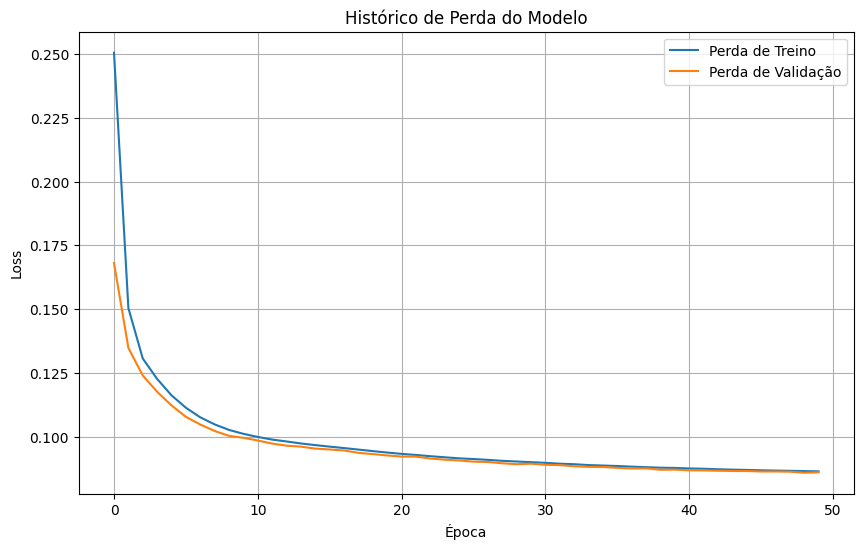

In [4]:
history = autoencoder.fit(x_train, x_train, # Note: input e target são os mesmos
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test),
                verbose=1)

# Plotando a perda de treino e validação
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Perda de Treino')
plt.plot(history.history['val_loss'], label='Perda de Validação')
plt.title('Histórico de Perda do Modelo')
plt.ylabel('Loss')
plt.xlabel('Época')
plt.legend()
plt.grid(True)
plt.show()


Agora, o momento da verdade! Vamos pegar algumas imagens do conjunto de teste,
passá-las pelo autoencoder e comparar as imagens originais com as reconstruídas.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


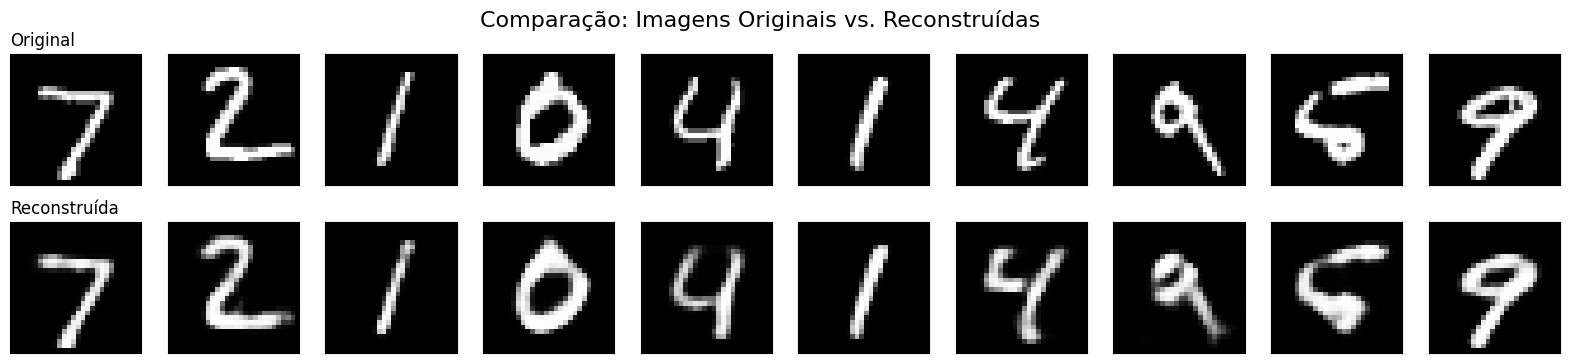

In [7]:
# Usando o modelo treinado para prever (reconstruir) as imagens de teste
decoded_imgs = autoencoder.predict(x_test)

# Plotando os resultados
n = 10  # Quantidade de dígitos para exibir
plt.figure(figsize=(20, 4))
for i in range(n):
    # Imagem original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == 0:
        ax.set_title("Original", loc='left')

    # Imagem reconstruída
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if i == 0:
        ax.set_title("Reconstruída", loc='left')

plt.suptitle("Comparação: Imagens Originais vs. Reconstruídas", fontsize=16)
plt.show()

**Observação:** As imagens reconstruídas são um pouco borradas, o que é esperado.
Isso acontece porque o autoencoder é um modelo com perdas (*lossy*).
 No entanto, ele conseguiu capturar as características essenciais para
 reconstruir uma versão reconhecível do dígito original, mesmo após a
 compressão massiva de 784 para 32 dimensões.

O que a representação comprimida (espaço latente) aprendeu?
Se construirmos um modelo onde o `encoding_dim` é 2, podemos plotar a representação de cada dígito em um gráfico 2D e ver se o autoencoder aprendeu a agrupar dígitos semelhantes.

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


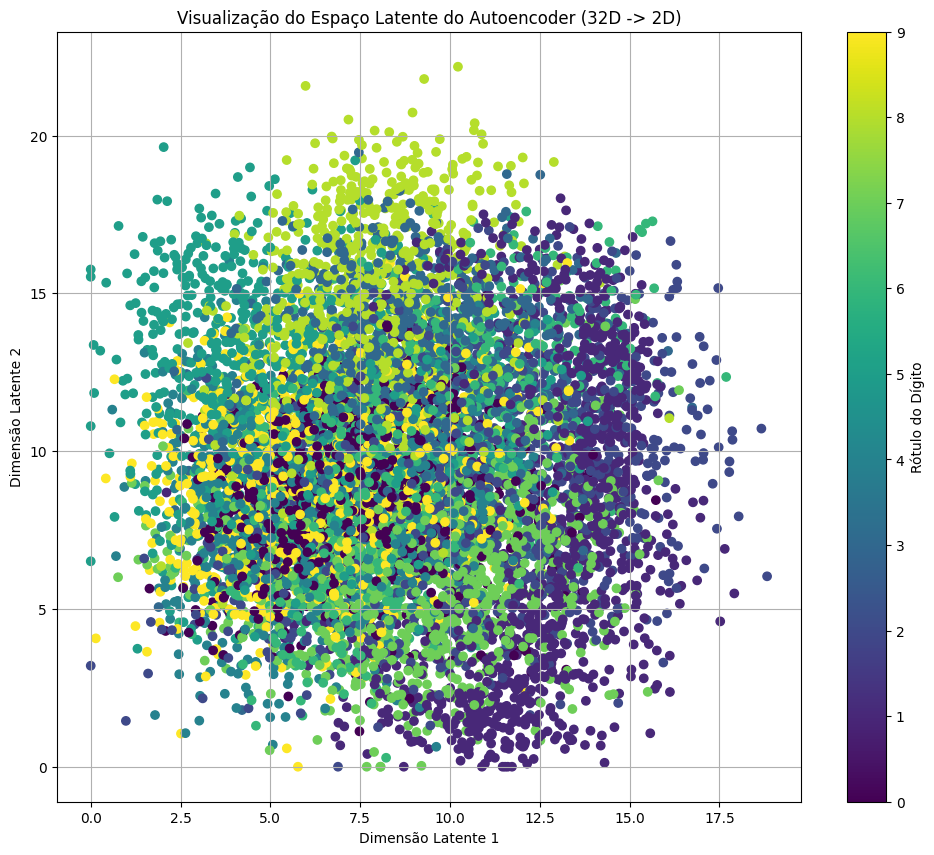

In [8]:
# Criando um modelo separado apenas para o encoder
encoder = Model(input_img, encoded)

# Passando as imagens de teste pelo encoder para obter suas representações no espaço latente
x_test_encoded = encoder.predict(x_test)

# Plotando o espaço latente 2D
plt.figure(figsize=(12, 10))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test, cmap='viridis')
plt.colorbar(label='Rótulo do Dígito')
plt.title('Visualização do Espaço Latente do Autoencoder (32D -> 2D)')
plt.xlabel('Dimensão Latente 1')
plt.ylabel('Dimensão Latente 2')
plt.grid(True)
plt.show()


**Conclusão:** Mesmo sem usar os rótulos durante o treino, o autoencoder aprendeu a organizar o espaço latente de forma que dígitos visualmente semelhantes fiquem próximos uns dos outros. Isso demonstra sua poderosa capacidade de extração de características de forma não supervisionada. Vemos clusters distintos para os diferentes dígitos, o que é um resultado impressionante.